# **Projet 4 : Anticipate the electricity consumption needs of buildings**

# **Summary**

This part consisted of testing and evaluating several regressors for the prediction of the SiteEnergyUse (kBtu) (energy) and TotalGHGEmissions (CO2 emissions) variables.

The dataset has been separated into a training and validation set.

A preprocessing pipeline has been defined, it fits different stages which apply to numerical and categorical variables (encoding, standardization, ...).

Several regressors were chosen:

'Linear': LinearRegression (),
'Ridge': Ridge (),
'Lasso': Lasso (),
'Elastic Net': ElasticNet (),
'SVR': SVR (kernel = "rbf", gamma = 1),
'Decision Tree': DecisionTreeRegressor(),
'Random Forest': RandomForestRegressor (n_estimators = 100, n_jobs = -1),

Two metrics were selected to evaluate our models: RMSE and R2

After comparing the scores obtained for each model, RandomForestRegressor was chosen for the prediction of the two targets.

For each target:

an optimization was carried out via a search for the best hyperparameters (GridSearch),
a graph of the importance of the contribution of each variable has been edited (features_importance_plot).

This last point was able to show that the variable EnergyStarScore has a relatively low importance for the prediction of TotalGHGEmissions.

From this graph it was possible to select the most important variables for the model, thus allowing it to be optimized. The visualization of this optimization was highlighted by the learning curves. The removal of unfortunate variables allowing to reduce the computation time, to reduce the overfitting. However, the two models created have a certain amount of bias.

# **Table of Contents**

*   Summary
*   Bibliography
*   Bibliography
*   Contexte
*   Librairies and dataframe's Import
*   Modelization
   *   Train test Split
   *   Preprocessor
   *   Pipeline
   *   Modeling
      *   SiteEnergyUse(kBtu)
      *   TotalGHGEmissions
*   Let's summarize the results
*   Model optimization - variable energy
*   Model optimization - variable emissions
*   Variable ENERGYSTARScore

















# **Bibliography**

Elastic Net https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

SVM https://www.analyticsvidhya.com/blog/2020/03support-vector-regression-tutorial-for-machine-learning/

Gradient Boosting regression https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

Linear regression models https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Metrics https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/

MODEL SELECTION AND EVALUATION https://scikit-learn.org/stable/model_selection.html



# **Contexte**

To meet the goal of being a carbon neutral city by 2050, the City of Seattle is paying close attention to emissions from non-residential buildings.

Careful readings were carried out in 2015 and 2016. However, these readings are expensive to obtain, and from those already carried out, we must try to predict the CO2 emissions and the total energy consumption of the buildings for which they have not yet been measured.

The first part allowed us to perform file cleaning and a short exploratory analysis. In this second part, we will carry out the various models in order to predict the CO2 emissions and the energy consumption of buildings.

# Librairies and dataframe's Import

In [ ]:
# Librairies communes pour le ML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Transformers
!pip install category_encoders 
import category_encoders as ce
from category_encoders import BaseNEncoder
from sklearn.preprocessing import RobustScaler

# Imputers
from sklearn.impute import SimpleImputer

# Cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

# Regressors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data= pd.read_csv('/content/drive/MyDrive/dataset_clean_projet_4.csv',low_memory=False)

Let’s take a look at the top five rows using the DataFrame’s head() method

In [ ]:
data.head(2)

,Unnamed: 0,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu)log,TotalGHGEmissionslog,GFABuildingRate,GFAParkingRate
0,312,442,2015,NonResidential,Large Office,KING BROADCASTING,333 DEXTER AVE N,LAKE UNION,47.621476,-122.343050,1947,1.0,155934.0,"Data Center, Office, Other, Parking, Restaurant",Office,59.0,105.8,332.3,16760217.0,0.0,16760914.0,0.0,116.84,0.23,16.634519,4.769328,0.80466,0.19534
1,358,499,2015,NonResidential,Small- and Mid-Sized Office,ASIAN COUNSELING and REFERRAL SERVICE BUILDING,3639 MARTIN LUTHER KING JR WAY S,GREATER DUWAMISH,47.570897,-122.297412,2008,1.0,55188.0,"Office, Parking",Office,76.0,81.1,169.8,4476997.0,0.0,2234200.0,2242889.0,134.69,1.63,15.314463,4.910373,0.72049,0.27951


The info() method is useful to get a quick description of the data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 788 non-null    int64  
 1   OSEBuildingID              788 non-null    int64  
 2   DataYear                   788 non-null    int64  
 3   BuildingType               788 non-null    object 
 4   PrimaryPropertyType        788 non-null    object 
 5   PropertyName               788 non-null    object 
 6   Address                    788 non-null    object 
 7   Neighborhood               788 non-null    object 
 8   Latitude                   788 non-null    float64
 9   Longitude                  788 non-null    float64
 10  YearBuilt                  788 non-null    int64  
 11  NumberofBuildings          788 non-null    float64
 12  PropertyGFABuilding(s)     788 non-null    float64
 13  ListOfAllPropertyUseTypes  788 non-null    object 

The describe() method is useful to get a quick numeric description of the data

In [ ]:
# To have an overview of descriptive statistics
data.describe()

,Unnamed: 0,OSEBuildingID,DataYear,Latitude,Longitude,YearBuilt,NumberofBuildings,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu)log,TotalGHGEmissionslog,GFABuildingRate,GFAParkingRate
count,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,7.880000e+02,474.000000,788.000000,788.000000,7.880000e+02,7.880000e+02,7.880000e+02,7.880000e+02,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000
mean,1234.659898,14444.585025,2015.986041,47.614304,-122.333585,1964.059645,1.034264,1.191573e+05,66.913502,72.548604,183.840990,8.020746e+06,2.886622e+05,6.259002e+06,1.472638e+06,144.127018,1.425457,15.142365,4.136389,0.902221,0.097779
std,995.398564,13932.613592,0.117397,0.043052,0.021937,33.999593,0.691273,1.906291e+05,27.527709,54.493926,133.684708,1.192495e+07,1.634182e+06,1.018096e+07,3.063211e+06,242.033430,1.740399,1.227514,1.320181,0.166747,0.166747
min,1.000000,2.000000,2015.000000,47.510180,-122.407650,1900.000000,0.000000,1.092500e+04,1.000000,3.500000,11.100000,1.119697e+05,0.000000e+00,6.746200e+04,0.000000e+00,0.790000,0.020000,11.625993,0.582216,0.201830,0.000000
25%,372.750000,524.750000,2016.000000,47.592220,-122.341772,1930.000000,1.000000,3.000000e+04,52.000000,39.275000,100.125002,1.532312e+06,0.000000e+00,9.101742e+05,0.000000e+00,24.955000,0.350000,14.242288,3.256364,0.821330,0.000000
50%,904.500000,20196.500000,2016.000000,47.611145,-122.333430,1970.000000,1.000000,5.267700e+04,75.000000,56.250000,150.500000,3.520094e+06,0.000000e+00,2.437086e+06,4.322415e+05,58.435000,0.800000,15.073990,4.084883,1.000000,0.000000
75%,2067.250000,24348.750000,2016.000000,47.633475,-122.324922,1992.000000,1.000000,1.159485e+05,89.000000,85.425001,221.049999,8.785666e+06,0.000000e+00,6.863507e+06,1.543894e+06,156.302500,1.742500,15.988626,5.058170,1.000000,0.178670
max,3375.000000,50226.000000,2016.000000,47.733870,-122.262350,2015.000000,14.000000,1.632820e+06,100.000000,298.299988,874.099976,9.293764e+07,2.147409e+07,8.785186e+07,3.285351e+07,2451.580000,11.120000,18.347439,7.804896,1.000000,0.798170


let's get an idea about the distribution of histograms of variables in the dataset.

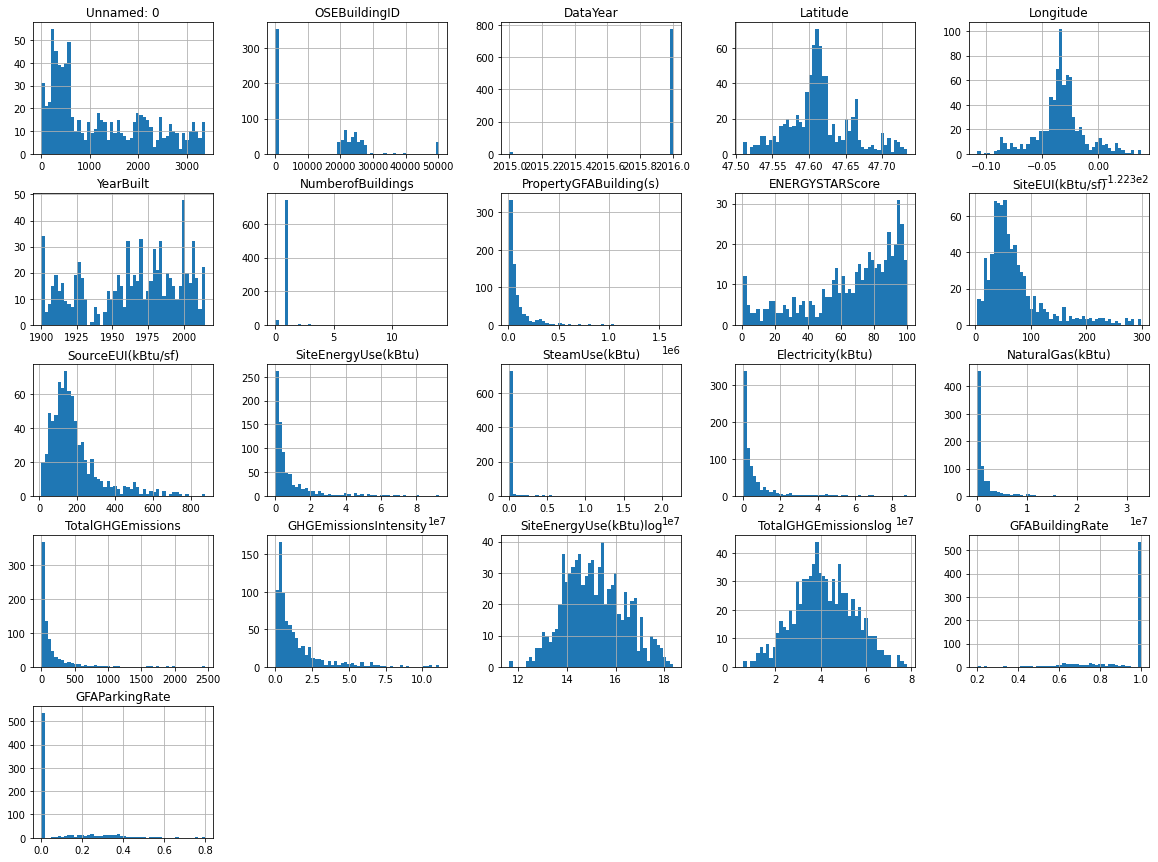

In [ ]:
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

It is necessary to treat the numerical values ​​before the modelization.

# Modelization

We are going to group together the building identification data so that they do not disturb our models but remain usable.

In [ ]:
identification_features = ['OSEBuildingID', 'PropertyName', 'Address']
data_identification = data[identification_features]
data.drop(identification_features, axis=1, inplace = True)

The goal of our program is to eliminate costly statements for years to come. We are therefore going to exclude all survey data from our dataset. We will also drop the target variables before transformation with log.

In [ ]:
data = data.drop(['SteamUse(kBtu)','Electricity(kBtu)', 'SiteEnergyUse(kBtu)',
                  'TotalGHGEmissions','NaturalGas(kBtu)'], axis=1)

Now we will see the correlations between our variables.

In [ ]:
# Using the correlation matrix to observe features and target correlations.
corr_matrix = data.corr()

In [ ]:
# To see the different correlations between our variables
corr_matrix["SiteEnergyUse(kBtu)log"].sort_values(ascending=False)

SiteEnergyUse(kBtu)log    1.000000
TotalGHGEmissionslog      0.876171
PropertyGFABuilding(s)    0.636212
SourceEUI(kBtu/sf)        0.536301
SiteEUI(kBtu/sf)          0.502250
GFAParkingRate            0.289469
YearBuilt                 0.281990
GHGEmissionsIntensity     0.274662
NumberofBuildings         0.113456
Latitude                  0.039239
Longitude                 0.021167
DataYear                 -0.005714
ENERGYSTARScore          -0.039057
GFABuildingRate          -0.289469
Unnamed: 0               -0.426520
Name: SiteEnergyUse(kBtu)log, dtype: float64

We notice a certain correlation between the target variables and the variable "PropertyGFABuilding (s)", let us do a figure for this correlation.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f07d5f1e090>,
      dtype=object)

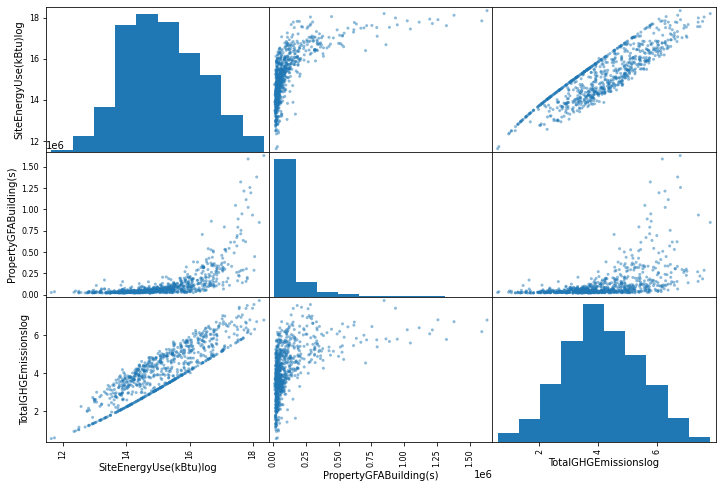

In [ ]:
from pandas.plotting import scatter_matrix
attributes = ["SiteEnergyUse(kBtu)log", "PropertyGFABuilding(s)", "TotalGHGEmissionslog"]
scatter_matrix(data[attributes], figsize=(12, 8))

The variable DataYear will not be useful to us here, we will remove it from the dataset. ENERGYSTARScore is insufficiently completed. We are going to remove it from the dataset but we will keep it to then check if this variable has an impact on the quality of the prediction.

In [ ]:
data = data.drop (['DataYear', 'Unnamed: 0'],axis=1)

In [ ]:
# Definition of features
features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'Latitude',
           'Longitude', 'YearBuilt', 'NumberofBuildings', 'PropertyGFABuilding(s)',
           'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
           'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'GHGEmissionsIntensity',
           'GFABuildingRate','GFAParkingRate','ENERGYSTARScore']
targets = ['SiteEnergyUse(kBtu)log', 'TotalGHGEmissionslog']          

In [ ]:
# Definition of numerical and categorical variables
num_cols = data[features].select_dtypes(include=['int64', 'float64']).columns
cat_cols = data[features].select_dtypes(include=['object', 'bool']).columns

**1. Train Test Split**

Before we look at the data any further, we need to create a
test set, put it aside, and never look at it. For this we will divide the dataset into two parts.

In [ ]:
# Split into training and testing set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, train_size=0.8, random_state=42)

**2. Preprocessor**

We are going to use the BinaryEncoder to encode categorical variables. Binary encoding is a combination of Hash encoding and one-hot encoding. In this encoding scheme, the categorical feature is first converted into numerical using an ordinal encoder. Then the numbers are transformed in the binary number. After that binary value is split into different columns. Binary encoding works really well when there are a high number of categories.

We will use the robustScaler to standardize the numeric variables. This can be achieved by calculating the median (50th percentile) and the 25th and 75th percentiles. The values of each variable then have their median subtracted and are divided by the interquartile range (IQR) which is the difference between the 75th and 25th percentiles.
value = (value – median) / (p75 – p25) The resulting variable has a zero mean and median and a standard deviation of 1, although not skewed by outliers and the outliers are still present with the same relative relationships to other values.

All the steps are nested in preprocessor via ColumnTransformer.

In [ ]:
# Preprocessing for numerical data
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('robust_scaler', RobustScaler()),  
])

# Preprocessing for categorical data
categorical_transformer = Pipeline([
    ('encoder', ce.BaseNEncoder()), 
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
    ])

**3. Pipeline**

In [ ]:
# Bundle preprocessing and modeling code in a pipeline

def pipeline(preprocessor, regressor):

    modeling_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                        ('regressor', regressor)
                                        ])

    return modeling_pipeline

In [ ]:
X_train = train_set[features]
y_trainEnergy = train_set['SiteEnergyUse(kBtu)log']
y_trainEmissions = train_set['TotalGHGEmissionslog']

X_test = test_set[features]
y_testEnergy = test_set['SiteEnergyUse(kBtu)log']
y_testEmissions = test_set['TotalGHGEmissionslog']

**4. Modeling**

## **SiteEnergyUse(kBtu)log**

### **Linear regression**

**1. Training and Evaluating on the Training Set**

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
regR = pipeline(preprocessor, lin_reg)
regR.fit(X_train, y_trainEnergy)

train_score = regR.score(X_train, y_trainEnergy)
print('Train score:', train_score)

Train score: 0.7948174191154529


We get a score of 79% OF R2 on the training data, which is not bad.

**2. Evaluation Using Cross-Validation**

One way to evaluate the Linear Regression model would be to use the train_test_split function to split the training set into a smaller training set and a validation set, then train the models against the smaller training set and evaluate them against the validation set.

First of all, we will use the r2. The r2_score function computes the coefficient of determination, usually denoted as R².

It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance. Best possible score is 1.0

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

scores = cross_val_score (regR, X_train, y_trainEnergy,
                 cv=10, scoring = 'r2')

In [ ]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(scores)

Scores: [0.7528576  0.70378826 0.71631728 0.78039402 0.66148114 0.72976538
 0.80643914 0.75903638 0.75436677 0.88954629]
Mean: 0.7553992239336521
Standard deviation: 0.05908874237357544


In [ ]:
scores = cross_val_score(regR, X_train, y_trainEnergy, scoring="r2", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean      0.755399
std       0.062285
min       0.661481
25%       0.719679
50%       0.753612
75%       0.775055
max       0.889546
dtype: float64

The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.

In [ ]:
scores = cross_val_score(regR, X_train, y_trainEnergy, scoring="neg_root_mean_squared_error", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean     -0.599195
std       0.113561
min      -0.780430
25%      -0.658899
50%      -0.606087
75%      -0.542858
max      -0.426589
dtype: float64

The unified scoring API always maximizes the score, so scores which need to be minimized are negated in order for the unified scoring API to work correctly. The score that is returned is therefore negated when it is a score that should be minimized and left positive if it is a score that should be maximized.

**3. Grid Search**

In [ ]:
# To get the differents algorithm parameters
regR.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'regressor', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__robust_scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__robust_scaler__copy', 'preprocessor__num__robust_scaler__quantile_range', 'preprocessor__num__robust_scaler__with_centering', 'preprocessor__num__robust_scaler__with_scaling', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__encoder

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {"preprocessor__n_jobs":[True,False],
             "regressor__fit_intercept":[True, False]}


lin_reg = LinearRegression()
regR = pipeline(preprocessor, lin_reg)
regR.fit(X_train, y_trainEnergy)

grid_search = GridSearchCV(regR, param_grid, cv=5, 
              return_train_score=True, scoring='r2')
grid_search.fit(X_train, y_trainEnergy)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
grid_search.best_score_

0.7465908777090403

In [ ]:
grid_search.best_params_

{'preprocessor__n_jobs': True, 'regressor__fit_intercept': True}

**4. Evaluation Using learning curves**

The learning curves show the evolution of the model's performance as a function of the quantity of data provided to it. Typically the more data the machine has to train, the better its performance. But when you reach the ceiling it is not useful to give more data.

[100 145 190 235 280 324 369 414 459 504]


Text(0.5, 1.0, 'learning_curves')

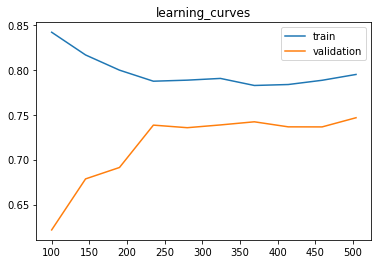

In [ ]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(regR, X_train, y_trainEnergy, train_sizes = np.linspace(0.2, 1.0, 10), cv=5)
print(N)

plt.plot(N, train_score.mean(axis=1), label = 'train')
plt.plot(N, val_score.mean(axis=1), label = 'validation')
plt.plot(xlabel='train size', ylabel='score')
plt.legend()
plt.title('learning_curves')

First, let’s look at the performance on the training data: when there are just a little of instances in the training set, the model can fit them perfectly, which is why the curve starts at 84 %. But as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly. Now let’s look at the performance of the model on the validation data. When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. Then as the model is shown more training examples, it learns and thus the validation error slowly goes down. I think that we need more data to better see the behavior of the model in the presence of more data.
Also we can use a more complex model or come up with better features.

**5. Evaluating on the Test Set**

In [ ]:
y_pred = regR.predict(X_test)

In [ ]:
from sklearn import metrics
print('r2:', metrics.r2_score(y_testEnergy, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_testEnergy, y_pred)))

r2: 0.7428917723579005
Root Mean Squared Error: 0.6203414188343702


We notice that the model generalizes worse with the test set than with the train set.

___

### **ElasticNet**

It is almost always better to have at least some regularization. we think only a few features are really useful, we might prefer Elastic Net as it tend to reduce the weight of unnecessary features up to zero as we have discussed. Elastic-net is useful when there are multiple features that are correlated with one another.

**1. Training and Evaluating on the Training Set**

In [ ]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
regE = pipeline(preprocessor, elastic_net)
regE.fit(X_train, y_trainEnergy)
print('Train score:', train_score.mean())

Train score: 0.797268502298362


This is a good score.

**2. Evaluation Using Cross-Validation**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

scores = cross_val_score (regE, X_train, y_trainEnergy,
                 cv=10, scoring = 'r2')

In [ ]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(scores)

Scores: [0.75392725 0.65954445 0.68226582 0.74140812 0.64787281 0.72055527
 0.74367298 0.72818508 0.75662668 0.84477181]
Mean: 0.7278830273975483
Standard deviation: 0.05367145485424268


In [ ]:
scores = cross_val_score(regE, X_train, y_trainEnergy, scoring="r2", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean      0.727883
std       0.056575
min       0.647873
25%       0.691838
50%       0.734797
75%       0.751364
max       0.844772
dtype: float64

In [ ]:
scores = cross_val_score(regE, X_train, y_trainEnergy, scoring="neg_root_mean_squared_error", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean     -0.633831
std       0.104670
min      -0.795962
25%      -0.697747
50%      -0.625325
75%      -0.550767
max      -0.505714
dtype: float64

**3. Grid Search**

In [ ]:
# To get the differents algorithm parameters
regE.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'regressor', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__robust_scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__robust_scaler__copy', 'preprocessor__num__robust_scaler__quantile_range', 'preprocessor__num__robust_scaler__with_centering', 'preprocessor__num__robust_scaler__with_scaling', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__encoder

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'regressor__l1_ratio' :np.arange(0.0, 1.0, 0.1) , 
              'regressor__alpha' :[0.0001, 0.001, 0.01, 0.1, 1, 10],
              'regressor__fit_intercept':[True, False]
             }
             
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
regE = pipeline(preprocessor, elastic_net)
regE.fit(X_train, y_trainEnergy)

grid_search = GridSearchCV(regE, param_grid, cv=5, 
              return_train_score=True, scoring='r2')
grid_search.fit(X_train, y_trainEnergy)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
grid_search.best_score_

0.7562198105394764

In [ ]:
grid_search.best_params_

{'regressor__alpha': 0.1,
 'regressor__fit_intercept': True,
 'regressor__l1_ratio': 0.0}

In [ ]:
modelE = grid_search.best_estimator_

**4. Evaluation Using learning curves**

The learning curves show the evolution of the model's performance as a function of the quantity of data provided to it. Typically the more data the machine has to train, the better its performance. But when you reach the ceiling it is not useful to give more data.

[100 145 190 235 280 324 369 414 459 504]


Text(0.5, 1.0, 'learning_curves')

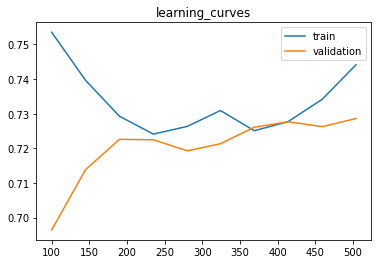

In [ ]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(regE, X_train, y_trainEnergy, train_sizes = np.linspace(0.2, 1.0, 10), cv=5)
print(N)

plt.plot(N, train_score.mean(axis=1), label = 'train')
plt.plot(N, val_score.mean(axis=1), label = 'validation')
plt.plot(xlabel='train size', ylabel='score')
plt.legend()
plt.title('learning_curves')

**5. Evaluating on the Test Set**

In [ ]:
y_pred = regE.predict(X_test)

In [ ]:
from sklearn import metrics
print('r2:', metrics.r2_score(y_testEnergy, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_testEnergy, y_pred)))

r2: 0.6912422828242608
Root Mean Squared Error: 0.6798008485786305


The model does not behave the same with the train set and the test set. It gives an r2 score of 99% which is a very interesting score with the train set, but only 64% with the test set.

___

### **Support Vector Regression : SVR** 

Support Vector Regression is a supervised learning algorithm that is used to predict discrete values. Support Vector Regression uses the same principle as the SVMs. The basic idea behind SVR is to find the best fit line. In SVR, the best fit line is the hyperplane that has the maximum number of points.

**1. Training and Evaluating on the Training Set**

In [ ]:
from sklearn.svm import SVR

svr = SVR()
regS = pipeline(preprocessor, svr)


In [ ]:
regS.fit(X_train, y_trainEnergy)
print('Train score Energy:', train_score.mean())

Train score Energy: 0.7334781317439765


**2. Evaluation Using Cross-Validation**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

scores = cross_val_score (regS, X_train, y_trainEnergy,
                 cv=10, scoring = 'r2')

In [ ]:
scores = cross_val_score(regS, X_train, y_trainEnergy, scoring="r2", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean      0.890240
std       0.022805
min       0.841784
25%       0.882839
50%       0.890383
75%       0.904849
max       0.925837
dtype: float64

**3. Grid Search**

In [ ]:
# To get the differents algorithm parameters
regS.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'regressor', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__robust_scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__robust_scaler__copy', 'preprocessor__num__robust_scaler__quantile_range', 'preprocessor__num__robust_scaler__with_centering', 'preprocessor__num__robust_scaler__with_scaling', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__encoder

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'regressor__epsilon':(0.0, 1.0, 0.1) , 
              'regressor__kernel':('linear', 'poly', 'rbf')
             }
             
svr = SVR()
regS = pipeline(preprocessor, svr)
regS.fit(X_train, y_trainEnergy)

grid_search = GridSearchCV(regS, param_grid, cv=5, 
              return_train_score=True, scoring='r2')
grid_search.fit(X_train, y_trainEnergy)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
grid_search.best_score_

0.8865494267593176

In [ ]:
# To get the best estimator for SiteEnergyUse(kBtu)log
modelS = grid_search.best_estimator_

**4. Evaluation Using learning curves**

[100 145 190 235 280 324 369 414 459 504]


Text(0.5, 1.0, 'learning_curves')

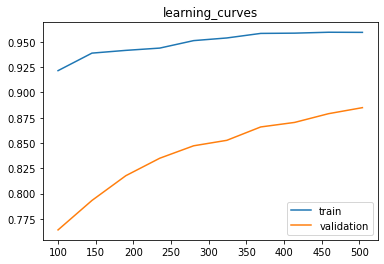

In [ ]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(regS, X_train, y_trainEnergy, train_sizes = np.linspace(0.2, 1.0, 10), cv=5)
print(N)

plt.plot(N, train_score.mean(axis=1), label = 'train')
plt.plot(N, val_score.mean(axis=1), label = 'validation')
plt.plot(xlabel='train size', ylabel='score')
plt.legend()
plt.title('learning_curves')

The training curve increases according to the data until an r2 score of 90%. While the validation curve starts at an r2 score of 70% and increases with the data. The large difference between the two curves indicates a large variance.

**5. Evaluating on the Test Set**

In [ ]:
y_pred = regS.predict(X_test)

In [ ]:
from sklearn import metrics
print('r2:', metrics.r2_score(y_testEnergy, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_testEnergy, y_pred)))

r2: 0.9111868591356026
Root Mean Squared Error: 0.36459558578044476


This model generalizes well on the test data with a score of 91% for the TotalGHGEmissionslog.

___

### **DecisionTreeRegressor**

This is a powerful model, capable of finding
complex nonlinear relationships in the data.
Decision tree builds regression or classification models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes.

**1. Training and Evaluating on the Training Set**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
regD = pipeline(preprocessor, tree_reg)
regD.fit(X_train, y_trainEnergy)

print('Train score:', train_score.mean())

Train score: 0.9488001326954582


This is a good score because the best value that can take the r2 is 1.

**2. Evaluation Using Cross-Validation**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

scores = cross_val_score (regD, X_train, y_trainEnergy,
                 cv=10, scoring = 'r2')

In [ ]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(scores)

Scores: [0.89745491 0.92750421 0.95606058 0.86743442 0.93166949 0.91180029
 0.9218683  0.94088105 0.89674827 0.87285707]
Mean: 0.9124278592045872
Standard deviation: 0.027314367135073084


In [ ]:
scores = cross_val_score(regD, X_train, y_trainEnergy, scoring="r2", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean      0.913337
std       0.025366
min       0.871825
25%       0.900146
50%       0.922070
75%       0.930062
max       0.947803
dtype: float64

**3. Grid Search**

In [ ]:
# To get the differents algorithm parameter
regD.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'regressor', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__robust_scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__robust_scaler__copy', 'preprocessor__num__robust_scaler__quantile_range', 'preprocessor__num__robust_scaler__with_centering', 'preprocessor__num__robust_scaler__with_scaling', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__encoder

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {"regressor__splitter" : ['best', 'random'],
              "regressor__max_depth" : [2,4,6,8,10]
             }

tree_reg = DecisionTreeRegressor()
regD = pipeline(preprocessor, tree_reg)
regD.fit(X_train, y_trainEnergy)


grid_search = GridSearchCV(regD, param_grid, cv=5, 
              return_train_score=True, scoring='r2')
grid_search.fit(X_train, y_trainEnergy)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
grid_search.best_score_

0.9067941148950128

In [ ]:
grid_search.best_params_

{'regressor__max_depth': 8, 'regressor__splitter': 'best'}

In [ ]:
modelD = grid_search.best_estimator_

**4. Evaluation Using learning curves**

[100 145 190 235 280 324 369 414 459 504]


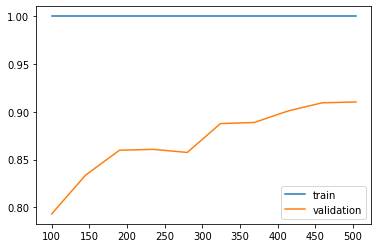

In [ ]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(regD, X_train, y_trainEnergy, train_sizes = np.linspace(0.2, 1.0, 10), cv=5)
print(N)

plt.plot(N, train_score.mean(axis=1), label = 'train')
plt.plot(N, val_score.mean(axis=1), label = 'validation')

plt.legend()

The model does not make an error on the set train.For the validation curve, the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. Then as the model is shown more training examples, it learns and thus the validation error slowly goes down. However, once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau.

**5. Evaluating on the Test Set**

In [ ]:
y_pred = regD.predict(X_test)

In [ ]:
from sklearn import metrics
print('r2:', metrics.r2_score(y_testEnergy, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_testEnergy, y_pred)))

r2: 0.9235721492433606
Root Mean Squared Error: 0.3382194781854603


The model behaves almost the same with the train set and the test set and it shows a very good r2 score.

___

### **RandomForestRegressor**

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1)
regF = pipeline(preprocessor, forest_reg)
regF.fit(X_train, y_trainEnergy)

train_score = regF.score(X_train, y_trainEnergy)
print('Train score:', train_score)

Train score: 0.9940284517165876


The model shows a very high score of r2.

**2. Evaluation Using Cross-Validation**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

scores = cross_val_score (regF, X_train, y_trainEnergy,
                 cv=10, scoring = 'r2')

In [ ]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(scores)

Scores: [0.96201125 0.96386611 0.96569052 0.9412591  0.97350079 0.95892293
 0.9558365  0.94614225 0.97499666 0.9551464 ]
Mean: 0.9597372510036714
Standard deviation: 0.010213546189175342


In [ ]:
scores = cross_val_score(regF, X_train, y_trainEnergy, scoring="r2", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean      0.959543
std       0.011046
min       0.942200
25%       0.955232
50%       0.958764
75%       0.964911
max       0.976913
dtype: float64

In [ ]:
scores = cross_val_score(regF, X_train, y_trainEnergy, scoring="neg_root_mean_squared_error", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean     -0.244956
std       0.037753
min      -0.314901
25%      -0.261316
50%      -0.240460
75%      -0.226756
max      -0.175558
dtype: float64

**3. Grid Search**

In [ ]:
# To get the differents algorithm parameters
regF.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'regressor', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__robust_scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__robust_scaler__copy', 'preprocessor__num__robust_scaler__quantile_range', 'preprocessor__num__robust_scaler__with_centering', 'preprocessor__num__robust_scaler__with_scaling', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__encoder

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {"regressor__bootstrap": [True, False], 
              "regressor__max_samples":[1,10,100],
             }

forest_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1)
regF = pipeline(preprocessor, forest_reg)
regF.fit(X_train, y_trainEnergy)


grid_search = GridSearchCV(regF, param_grid, cv=5, 
              return_train_score=True, scoring='r2')
grid_search.fit(X_train, y_trainEnergy)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
grid_search.best_score_

0.9309724541425572

In [ ]:
grid_search.best_params_

{'regressor__bootstrap': True, 'regressor__max_samples': 100}

In [ ]:
modelF = grid_search.best_estimator_

**4. Evaluation Using learning curves**

[100 145 190 235 280 324 369 414 459 504]


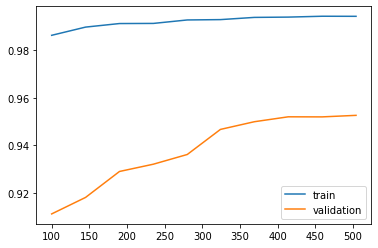

In [ ]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(regF, X_train, y_trainEnergy, train_sizes = np.linspace(0.2, 1.0, 10), cv=5)
print(N)

plt.plot(N, train_score.mean(axis=1), label = 'train')
plt.plot(N, val_score.mean(axis=1), label = 'validation')

plt.legend()

The training curve increases according to the data until an r2 score of 99%. While the validation curve starts at an r2 score of 90% and increases with the data. The large gap between the two curves indicates a large variance. 

**5. Evaluating on the Test Set**

In [ ]:
y_pred = regF.predict(X_test)

In [ ]:
from sklearn import metrics
print('r2:', metrics.r2_score(y_testEnergy, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_testEnergy, y_pred)))

r2: 0.9707034792815779
Root Mean Squared Error: 0.209401994945809


The model behaves almost the same with the train set and the test set and it shows a very good r2 score.

___

## **TotalGHGEmissions**

### **Linear regression**

**1. Training and Evaluating on the Training Set**

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
regR = pipeline(preprocessor, lin_reg)
regR.fit(X_train, y_trainEmissions)

train_score = regR.score(X_train, y_trainEmissions)
print('Train score:', train_score)

Train score: 0.7287979724225967


We get a score of 72% OF R2 on the training data, which is not bad.

**2. Evaluation Using Cross-Validation**

One way to evaluate the Linear Regression model would be to use the train_test_split function to split the training set into a smaller training set and a validation set, then train the models against the smaller training set and evaluate them against the validation set.

First of all, we will use the r2. The r2_score function computes the coefficient of determination, usually denoted as R².

It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance. Best possible score is 1.0

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

scores = cross_val_score (regR, X_train, y_trainEmissions,
                 cv=10, scoring = 'r2')

In [ ]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(scores)

Scores: [0.60242099 0.6488136  0.62507286 0.64850279 0.58046152 0.7443795
 0.70108315 0.63756438 0.70428268 0.77417275]
Mean: 0.6666754222515558
Standard deviation: 0.05914455339894071


In [ ]:
scores = cross_val_score(regR, X_train, y_trainEmissions, scoring="r2", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean      0.666675
std       0.062344
min       0.580462
25%       0.628196
50%       0.648658
75%       0.703483
max       0.774173
dtype: float64

In [ ]:
scores = cross_val_score(regR, X_train, y_trainEmissions, scoring="neg_root_mean_squared_error", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean     -0.760573
std       0.102881
min      -0.887301
25%      -0.843067
50%      -0.766879
75%      -0.692896
max      -0.609366
dtype: float64

**3. Grid Search**

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {"preprocessor__n_jobs":[True,False],
             "regressor__fit_intercept":[True, False]}


lin_reg = LinearRegression()
regR = pipeline(preprocessor, lin_reg)
regR.fit(X_train, y_trainEmissions)

grid_search = GridSearchCV(regR, param_grid, cv=5, 
              return_train_score=True, scoring='r2')
grid_search.fit(X_train, y_trainEmissions)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
grid_search.best_score_

0.6521999819346981

In [ ]:
grid_search.best_params_

{'preprocessor__n_jobs': True, 'regressor__fit_intercept': True}

**4. Evaluation Using learning curves**

[100 145 190 235 280 324 369 414 459 504]


Text(0.5, 1.0, 'learning_curves')

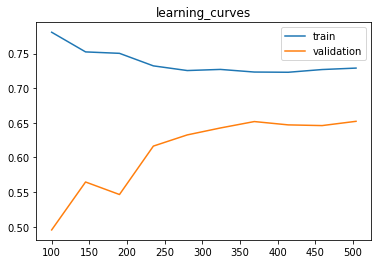

In [ ]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(regR, X_train, y_trainEmissions, train_sizes = np.linspace(0.2, 1.0, 10), cv=5)
print(N)

plt.plot(N, train_score.mean(axis=1), label = 'train')
plt.plot(N, val_score.mean(axis=1), label = 'validation')
plt.plot(xlabel='train size', ylabel='score')
plt.legend()
plt.title('learning_curves')

The training curve decreases according to the data until an r2 score of 72%. While the validation curve starts at an r2 score of 50% and increases with the data. The large gap between the two curves indicates a large variance.

**5. Evaluating on the Test Set**

In [ ]:
y_pred = regR.predict(X_test)

In [ ]:
from sklearn import metrics
print('r2:', metrics.r2_score(y_testEmissions, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_testEmissions, y_pred)))

r2: 0.6241888068994602
Root Mean Squared Error: 0.7817601065321934


We notice that the model generalizes in same way with the test set and the train set.

___

### **ElasticNet**

It is almost always better to have at least some regularization. we think only a few features are really useful, we might prefer Elastic Net as it tend to reduce the weight of unnecessary features up to zero as we have discussed. Elastic-net is useful when there are multiple features that are correlated with one another.

**1. Training and Evaluating on the Training Set**

In [ ]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
regE = pipeline(preprocessor, elastic_net)
regE.fit(X_train, y_trainEmissions)
print('Train score:', train_score.mean())

Train score: 0.737126194633838


This is a good score.

**2. Evaluation Using Cross-Validation**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

scores = cross_val_score (regE, X_train, y_trainEmissions,
                 cv=10, scoring = 'r2')

In [ ]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(scores)

Scores: [0.62185315 0.62588344 0.62905496 0.62251188 0.59031105 0.72791728
 0.66631211 0.64765642 0.72255252 0.72322672]
Mean: 0.6577279527195945
Standard deviation: 0.047436698248054944


In [ ]:
scores = cross_val_score(regE, X_train, y_trainEmissions, scoring="r2", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean      0.657728
std       0.050003
min       0.590311
25%       0.623355
50%       0.638356
75%       0.708492
max       0.727917
dtype: float64

In [ ]:
scores = cross_val_score(regE, X_train, y_trainEmissions, scoring="neg_root_mean_squared_error", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean     -0.771615
std       0.090556
min      -0.915810
25%      -0.829030
50%      -0.777120
75%      -0.688482
max      -0.654725
dtype: float64

**3. Grid Search**

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'regressor__l1_ratio' :np.arange(0.0, 1.0, 0.1) , 
              'regressor__alpha' :[0.0001, 0.001, 0.01, 0.1, 1, 10],
              'regressor__fit_intercept':[True, False]
             }
             
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
regE = pipeline(preprocessor, elastic_net)
regE.fit(X_train, y_trainEmissions)

grid_search = GridSearchCV(regE, param_grid, cv=5, 
              return_train_score=True, scoring='r2')
grid_search.fit(X_train, y_trainEmissions)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
grid_search.best_score_

0.6744852573018156

In [ ]:
grid_search.best_params_

{'regressor__alpha': 0.1,
 'regressor__fit_intercept': True,
 'regressor__l1_ratio': 0.0}

In [ ]:
modelE = grid_search.best_estimator_

**4. Evaluation Using learning curves**

The learning curves show the evolution of the model's performance as a function of the quantity of data provided to it. Typically the more data the machine has to train, the better its performance. But when you reach the ceiling it is not useful to give more data.

[100 145 190 235 280 324 369 414 459 504]


Text(0.5, 1.0, 'learning_curves')

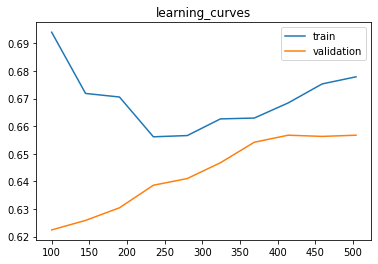

In [ ]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(regE, X_train, y_trainEmissions, train_sizes = np.linspace(0.2, 1.0, 10), cv=5)
print(N)

plt.plot(N, train_score.mean(axis=1), label = 'train')
plt.plot(N, val_score.mean(axis=1), label = 'validation')
plt.plot(xlabel='train size', ylabel='score')
plt.legend()
plt.title('learning_curves')

The gap between the two curves still important.

**5. Evaluating on the Test Set**

In [ ]:
y_pred = regE.predict(X_test)

In [ ]:
from sklearn import metrics
print('r2:', metrics.r2_score(y_testEmissions, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_testEmissions, y_pred)))

r2: 0.604177799470567
Root Mean Squared Error: 0.8023035677428635


the model does not generalize well with the test set.

___

### **Support Vector Regression : SVR** 

Support Vector Regression is a supervised learning algorithm that is used to predict discrete values. Support Vector Regression uses the same principle as the SVMs. The basic idea behind SVR is to find the best fit line. In SVR, the best fit line is the hyperplane that has the maximum number of points.

**1. Training and Evaluating on the Training Set**

In [ ]:
from sklearn.svm import SVR

svr = SVR()
regS = pipeline(preprocessor, svr)
regS.fit(X_train, y_trainEmissions)
print('Train score EnergyEmissions:', train_score.mean())

Train score EnergyEmissions: 0.669660066250504


**2. Evaluation Using Cross-Validation**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

scores = cross_val_score (regS, X_train, y_trainEmissions,
                 cv=10, scoring = 'r2')

In [ ]:
scores = cross_val_score(regS, X_train, y_trainEmissions, scoring="r2", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean      0.850399
std       0.031241
min       0.799744
25%       0.829326
50%       0.850138
75%       0.879439
max       0.886049
dtype: float64

**3. Grid Search**

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'regressor__epsilon':(0.0, 1.0, 0.1) , 
              'regressor__kernel':('linear', 'poly', 'rbf')
             }
             
svr = SVR()
regS = pipeline(preprocessor, svr)
regS.fit(X_train, y_trainEmissions)

grid_search = GridSearchCV(regS, param_grid, cv=5, 
              return_train_score=True, scoring='r2')
grid_search.fit(X_train, y_trainEmissions)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
grid_search.best_score_

0.8494644109980569

In [ ]:
# To get the best estimator for SiteEnergyUse(kBtu)log
modelS = grid_search.best_estimator_

**4. Evaluation Using learning curves**

[100 145 190 235 280 324 369 414 459 504]


Text(0.5, 1.0, 'learning_curves')

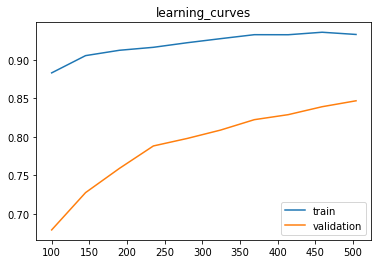

In [ ]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(regS, X_train, y_trainEmissions, train_sizes = np.linspace(0.2, 1.0, 10), cv=5)
print(N)

plt.plot(N, train_score.mean(axis=1), label = 'train')
plt.plot(N, val_score.mean(axis=1), label = 'validation')
plt.plot(xlabel='train size', ylabel='score')
plt.legend()
plt.title('learning_curves')

The training curve increases according to the data until an r2 score of 93%. While the validation curve starts at an r2 score of 70% and increases with the data. But the large gap between the two curves indiquate a high variance.

**5. Evaluating on the Test Set**

In [ ]:
y_pred = regS.predict(X_test)

In [ ]:
from sklearn import metrics
print('r2:', metrics.r2_score(y_testEmissions, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_testEmissions, y_pred)))

r2: 0.8822295465039774
Root Mean Squared Error: 0.43762973499872515


This model generalizes well on the test data with a score of 88% for the TotalGHGEmissionslog.

___

### **DecisionTreeRegressor**

This is a powerful model, capable of finding
complex nonlinear relationships in the data.
Decision tree builds regression or classification models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes.

**1. Training and Evaluating on the Training Set**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
regD = pipeline(preprocessor, tree_reg)
regD.fit(X_train, y_trainEmissions)

print('Train score:', train_score.mean())

Train score: 0.9201927029928769


This is a good score because the best value that can take the r2 is 1.

**2. Evaluation Using Cross-Validation**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

scores = cross_val_score (regD, X_train, y_trainEmissions,
                 cv=10, scoring = 'r2')

In [ ]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(scores)

Scores: [0.80373023 0.93378802 0.89435376 0.90911686 0.92355989 0.91563209
 0.9033953  0.92073651 0.94485381 0.87482733]
Mean: 0.9023993785970337
Standard deviation: 0.037885901828559984


In [ ]:
scores = cross_val_score(regD, X_train, y_trainEmissions, scoring="r2", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean      0.905604
std       0.041592
min       0.814945
25%       0.887507
50%       0.922998
75%       0.930859
max       0.940980
dtype: float64

**3. Grid Search**

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {"regressor__splitter" : ['best', 'random'],
              "regressor__max_depth" : [2,4,6,8,10]
             }

tree_reg = DecisionTreeRegressor()
regD = pipeline(preprocessor, tree_reg)
regD.fit(X_train, y_trainEmissions)


grid_search = GridSearchCV(regD, param_grid, cv=5, 
              return_train_score=True, scoring='r2')
grid_search.fit(X_train, y_trainEnergy)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
grid_search.best_score_

0.9103087526843907

In [ ]:
grid_search.best_params_

{'regressor__max_depth': 8, 'regressor__splitter': 'best'}

In [ ]:
modelD = grid_search.best_estimator_

**4. Evaluation Using learning curves**

[100 145 190 235 280 324 369 414 459 504]


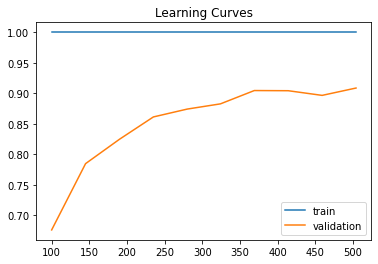

In [ ]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(regD, X_train, y_trainEmissions, train_sizes = np.linspace(0.2, 1.0, 10), cv=5)
print(N)

plt.plot(N, train_score.mean(axis=1), label = 'train')
plt.plot(N, val_score.mean(axis=1), label = 'validation')
plt.title('Learning Curves')
plt.legend()

The model does not make an error on the set train.For the validation curve, the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. Then as the model is shown more training examples, it learns and thus the validation error slowly goes down. However, once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau.

**5. Evaluating on the Test Set**

In [ ]:
y_pred = regD.predict(X_test)

In [ ]:
from sklearn import metrics
print('r2:', metrics.r2_score(y_testEmissions, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_testEmissions, y_pred)))

r2: 0.9308067758654739
Root Mean Squared Error: 0.33544431251033474


The model behaves almost the same with the train set and the test set and it shows a very good r2 score.

___

Now let's use a generalist method

### **RandomForestRegressor**

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1)
regF = pipeline(preprocessor, forest_reg)
regF.fit(X_train, y_trainEmissions)

train_score = regF.score(X_train, y_trainEmissions)
print('Train score:', train_score)

Train score: 0.9956564677223246


The model shows a very high score of r2.

**2. Evaluation Using Cross-Validation**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

scores = cross_val_score (regF, X_train, y_trainEmissions,
                 cv=10, scoring = 'r2')

In [ ]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(scores)

Scores: [0.92984078 0.96287304 0.97439725 0.96000171 0.98459683 0.97288756
 0.96967572 0.96508351 0.9814995  0.95671048]
Mean: 0.9657566374654053
Standard deviation: 0.014687849422076973


In [ ]:
scores = cross_val_score(regF, X_train, y_trainEmissions, scoring="r2", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean      0.965334
std       0.015769
min       0.927812
25%       0.961370
50%       0.968373
75%       0.975724
max       0.982267
dtype: float64

In [ ]:
scores = cross_val_score(regF, X_train, y_trainEmissions, scoring="neg_root_mean_squared_error", cv=10)
pd.Series((scores)).describe()

count    10.000000
mean     -0.239951
std       0.057231
min      -0.362986
25%      -0.263952
50%      -0.241167
75%      -0.189151
max      -0.178857
dtype: float64

**3. Grid Search**

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {"regressor__bootstrap": [True, False], 
              "regressor__max_samples":[1,10,100],
             }

forest_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1)
regF = pipeline(preprocessor, forest_reg)
regF.fit(X_train, y_trainEmissions)


grid_search = GridSearchCV(regF, param_grid, cv=5, 
              return_train_score=True, scoring='r2')
grid_search.fit(X_train, y_trainEmissions)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
grid_search.best_score_

0.9305453881724179

In [ ]:
grid_search.best_params_

{'regressor__bootstrap': True, 'regressor__max_samples': 100}

In [ ]:
modelF = grid_search.best_estimator_

**4. Evaluation Using learning curves**

[100 145 190 235 280 324 369 414 459 504]


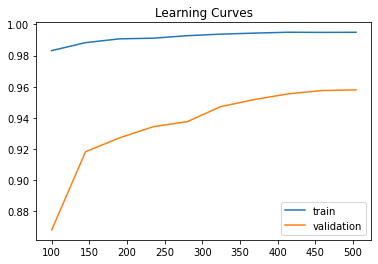

In [ ]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(regF, X_train, y_trainEmissions, train_sizes = np.linspace(0.2, 1.0, 10), cv=5)
print(N)

plt.plot(N, train_score.mean(axis=1), label = 'train')
plt.plot(N, val_score.mean(axis=1), label = 'validation')
plt.title('Learning Curves')
plt.legend()

We notice an important gap between the two curves.

**5. Evaluating on the Test Set**

In [ ]:
y_pred = regF.predict(X_test)

In [ ]:
from sklearn import metrics
print('r2:', metrics.r2_score(y_testEmissions, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_testEmissions, y_pred)))

r2: 0.9688489980695485
Root Mean Squared Error: 0.22507365257551537


The model behaves almost the same with the train set and the test set and it shows a very good r2 score.

___

### **Let's summarize the results**

In [ ]:
results = []
algos = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(tol=0.5),
    'ElasticNet' : ElasticNet(),
    'SVR': SVR(),
    'DecisionTreeRegressor' : DecisionTreeRegressor(),
    'RandomForestRegressor' : RandomForestRegressor()
}

**SiteEnergyUse(kBtu)log**

In [ ]:
for algo_name, algo in algos.items():
    print('Algorithm: ',algo_name)
    model = pipeline(preprocessor,algo)
    model.fit(X_train,y_trainEnergy)
    y_pred = model.predict(X_test)
    print('____Prediction of SiteEnergyUse____ ')
    print('training score = ',model.score(X_train,y_trainEnergy))
    print("prediction score: ",  model.score(X_test, y_testEnergy))
    rmse = np.sqrt(mean_squared_error(y_testEnergy,y_pred))
    r2 = r2_score(y_testEnergy,y_pred)     
    print("RMSE = ",rmse)
    print("r2 = ",r2)
    print('')
    results.append([algo_name, model.score(X_test, y_testEnergy), rmse, r2])
    print('-'*100)

Algorithm:  LinearRegression
____Prediction of SiteEnergyUse____ 
training score =  0.7948174191154529
prediction score:  0.7428917723579005
RMSE =  0.6203414188343702
r2 =  0.7428917723579005

----------------------------------------------------------------------------------------------------
Algorithm:  Ridge
____Prediction of SiteEnergyUse____ 
training score =  0.7944635858971132
prediction score:  0.7420256399749889
RMSE =  0.6213854267446589
r2 =  0.7420256399749889

----------------------------------------------------------------------------------------------------
Algorithm:  Lasso
____Prediction of SiteEnergyUse____ 
training score =  0.22161119018935072
prediction score:  0.3041861224267618
RMSE =  1.0205148643733006
r2 =  0.3041861224267618

----------------------------------------------------------------------------------------------------
Algorithm:  ElasticNet
____Prediction of SiteEnergyUse____ 
training score =  0.48132100834556535
prediction score:  0.5445642751459572


In [ ]:
X_train = preprocessor.transform((X_train))

LR: 0.750811 (0.065739)
Lasso: 0.205169 (0.044611)
Ridge: 0.752867 (0.063487)
ELN: 0.471341 (0.053271)
DTR: 0.912568 (0.026798)
RFR: 0.959141 (0.009948)


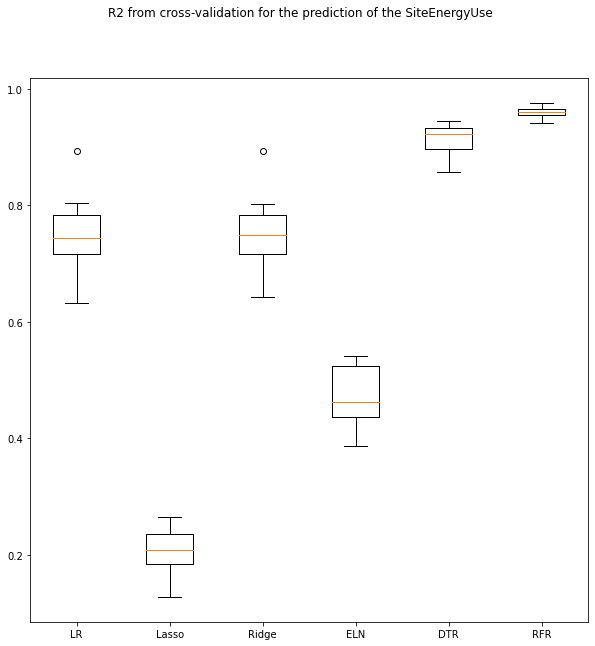

In [ ]:
# Set up 10-fold cross validation

scoring = 'r2'

models = []
models.append(('LR', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('Ridge', Ridge()))
models.append(('ELN', ElasticNet()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor()))


# evaluate each model in turn

results = []
names = []
from sklearn.model_selection import KFold
from sklearn import model_selection
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=42)
	cv_results = model_selection.cross_val_score(model, X_train, y_trainEnergy, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

# Compare Algorithms

fig = plt.figure(figsize=(10,10))
fig.suptitle('R2 from cross-validation for the prediction of the SiteEnergyUse')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

**TotalGHGEmissionslog**

In [ ]:
for algo_name, algo in algos.items():
    print('Algorithm: ',algo_name)
    model = pipeline(preprocessor,algo)
    model.fit(X_train,y_trainEmissions)
    y_pred = model.predict(X_test)
    print('____Prediction of TotalGHGEmissions____ ')
    print('training score = ',model.score(X_train,y_trainEmissions))
    print("prediction score: ",  model.score(X_test, y_testEmissions))
    rmse = np.sqrt(mean_squared_error(y_testEmissions,y_pred))
    r2 = r2_score(y_testEmissions,y_pred)     
    print("RMSE = ",rmse)
    print("r2 = ",r2)
    print('')
    results.append([algo_name, model.score(X_test, y_testEmissions), rmse, r2])
    print('-'*100)

Algorithm:  LinearRegression
____Prediction of TotalGHGEmissions____ 
training score =  0.7287979724225967
prediction score:  0.6241888068994602
RMSE =  0.7817601065321934
r2 =  0.6241888068994602

----------------------------------------------------------------------------------------------------
Algorithm:  Ridge
____Prediction of TotalGHGEmissions____ 
training score =  0.7282604612676289
prediction score:  0.6253657728885846
RMSE =  0.7805349879077519
r2 =  0.6253657728885846

----------------------------------------------------------------------------------------------------
Algorithm:  Lasso
____Prediction of TotalGHGEmissions____ 
training score =  0.08191055718018536
prediction score:  0.1226941687262445
RMSE =  1.194439500012665
r2 =  0.1226941687262445

----------------------------------------------------------------------------------------------------
Algorithm:  ElasticNet
____Prediction of TotalGHGEmissions____ 
training score =  0.43225267701814674
prediction score:  0.48

In [ ]:
X_train = preprocessor.transform((X_train))

LR: 0.669551 (0.058598)
Lasso: 0.073204 (0.014742)
Ridge: 0.672165 (0.056792)
ELN: 0.426245 (0.033574)
DTR: 0.912284 (0.025031)
RFR: 0.965629 (0.015103)


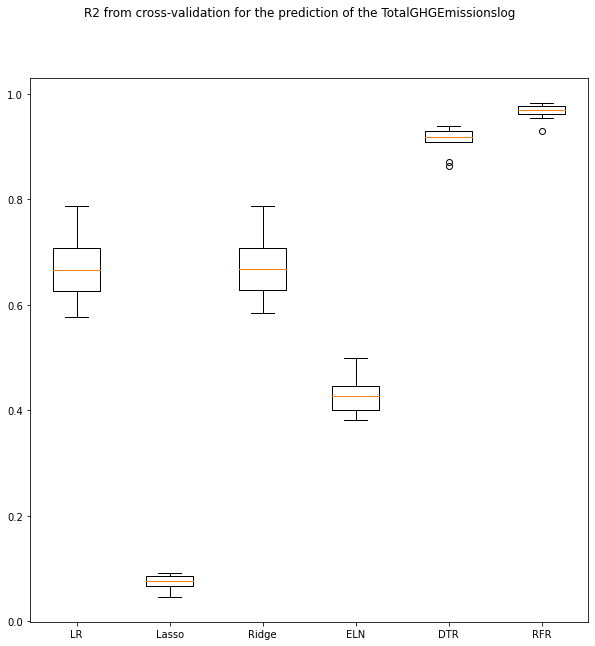

In [ ]:
# Set up 10-fold cross validation
scoring = 'r2'

models = []
models.append(('LR', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('Ridge', Ridge()))
models.append(('ELN', ElasticNet()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor()))


# evaluate each model in turn
results = []
names = []
from sklearn.model_selection import KFold
from sklearn import model_selection
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=42)
	cv_results = model_selection.cross_val_score(model, X_train, y_trainEmissions, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)


# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('R2 from cross-validation for the prediction of the TotalGHGEmissionslog')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

We will select the best model which is
RandomForestRegressor ().

### **Model optimization - variable energy**

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {"regressor__bootstrap": [True, False], # The use of priming samples during construction
              "regressor__max_samples":[1,10,100], # The number of samples to draw from X to train each base estimator
              "regressor__n_estimators" : [100,150,200], # Number of trees
              'regressor__max_depth' : range(1, 10, 1), # Number of maximum depths
             }

forest_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1)
regF = pipeline(preprocessor, forest_reg)
regF.fit(X_train, y_trainEnergy)

grid_search = GridSearchCV(regF, param_grid, cv=5, 
              return_train_score=True, scoring='r2')
grid_search.fit(X_train, y_trainEnergy)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
grid_search.best_params_

{'regressor__bootstrap': True,
 'regressor__max_depth': 9,
 'regressor__max_samples': 100,
 'regressor__n_estimators': 150}

In [ ]:
final_model = grid_search.best_score_

[100 145 190 235 280 324 369 414 459 504]


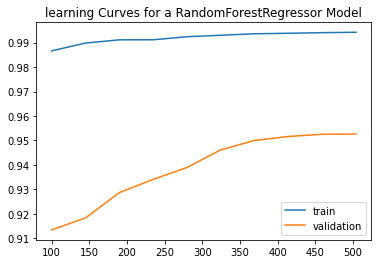

In [ ]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(regF, X_train, y_trainEnergy, train_sizes = np.linspace(0.2, 1.0, 10), cv=5)
print(N)

plt.plot(N, train_score.mean(axis=1), label = 'train')
plt.plot(N, val_score.mean(axis=1), label = 'validation')
plt.title('learning Curves for a RandomForestRegressor Model')

plt.legend()

The training curve increases according to the data until an r2 score of 99%. While the validation curve starts at an r2 score of 90% and increases with the data. The error on the training data is very small, it means that the training data has fitted very well to the model. The model performs very well on the training data, it means that it has a low bias against this data set. 
The large gap between the two curves indicates that our model suffers from an overerfitting problem caused by high variance. 
We can add other training data, eliminate features that don't add anything to the model, or try simpler models.

### **Model optimization - variable emissions**

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {"regressor__bootstrap": [True, False], # The use of priming samples during construction
              "regressor__max_samples":[1,10,100], # The number of samples to draw from X to train each base estimator
              "regressor__n_estimators" : [100,150,200], # Number of trees
              'regressor__max_depth' : range(1, 10, 1), # Number of maximum depths
             }

forest_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1)
regF = pipeline(preprocessor, forest_reg)
regF.fit(X_train, y_trainEmissions)

grid_search = GridSearchCV(regF, param_grid, cv=5, 
              return_train_score=True, scoring='r2')
grid_search.fit(X_train, y_trainEmissions)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
grid_search.best_params_

{'regressor__bootstrap': True,
 'regressor__max_depth': 7,
 'regressor__max_samples': 100,
 'regressor__n_estimators': 200}

In [ ]:
final_model = grid_search.best_score_

[100 145 190 235 280 324 369 414 459 504]


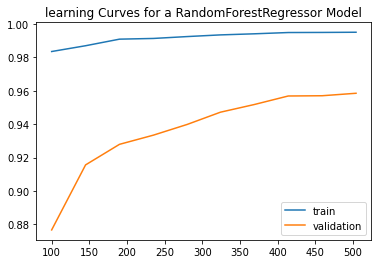

In [ ]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(regF, X_train, y_trainEmissions, train_sizes = np.linspace(0.2, 1.0, 10), cv=5)
print(N)

plt.plot(N, train_score.mean(axis=1), label = 'train')
plt.plot(N, val_score.mean(axis=1), label = 'validation')
plt.title('learning Curves for a RandomForestRegressor Model')
plt.legend()

The training curve increases according to the data until an r2 score of 99%. While the validation curve starts at an r2 score of 85% and increases with the data. The error on the training data is very small, it means that the training data has fitted very well to the model. The model performs very well on the training data, it means that it has a low bias against this data set. The large gap between the two curves indicates that our model suffers from an overerfitting problem caused by high variance. We can add other training data, eliminate features that don't add anything to the model, or try simpler models.

### **Variable ENERGYSTARScore**

As we have seen in the correlation matrix, the variable ENERGYSTARScore is not correlated to the two target variables. Let us see the effect of the absence of this variable on the chosen model.

In [ ]:
data = data.drop (['ENERGYSTARScore'],axis=1)

In [ ]:
# Definition of features
features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'Latitude',
           'Longitude', 'YearBuilt', 'NumberofBuildings', 'PropertyGFABuilding(s)',
           'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
           'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'GHGEmissionsIntensity',
           'GFABuildingRate','GFAParkingRate']
targets = ['SiteEnergyUse(kBtu)log', 'TotalGHGEmissionslog']          

In [ ]:
# Definition of numerical and categorical variables
num_colsf = data[features].select_dtypes(include=['int64', 'float64']).columns
cat_colsf = data[features].select_dtypes(include=['object', 'bool']).columns

In [ ]:
# Split into training and testing set
from sklearn.model_selection import train_test_split
train_set_final, test_set_final = train_test_split(data, train_size=0.8, random_state=42)

In [ ]:
# Preprocessing for numerical data
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('robust_scaler', RobustScaler()),  
])

# Preprocessing for categorical data
categorical_transformer = Pipeline([
    ('encoder', ce.BaseNEncoder()), 
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_colsf),
        ('cat', categorical_transformer, cat_colsf),
    ])

In [ ]:
# Bundle preprocessing and modeling code in a pipeline

def pipeline(preprocessor, regressor):

    modeling_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                        ('regressor', regressor)
                                        ])

    return modeling_pipeline

In [ ]:
X_train_final = train_set_final[features]
y_trainEnergy_final = train_set_final['SiteEnergyUse(kBtu)log']
y_trainEmissions_final = train_set_final['TotalGHGEmissionslog']

X_test_final = test_set_final[features]
y_testEnergy_final = test_set_final['SiteEnergyUse(kBtu)log']
y_testEmissions_final = test_set_final['TotalGHGEmissionslog']

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1)
regF = pipeline(preprocessor, forest_reg)
regF.fit(X_train_final, y_trainEnergy_final)

train_score = regF.score(X_train_final, y_trainEnergy_final)
print('Train score:', train_score)

Train score: 0.9945950051494683


In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1)
regF = pipeline(preprocessor, forest_reg)
regF.fit(X_train_final, y_trainEmissions_final)

train_score = regF.score(X_train_final, y_trainEmissions_final)
print('Train score:', train_score)

Train score: 0.995464829174805


As we have seen in the correlation matrix of dataset variables at the start of the notebook, the variable ENERGYStarScore has no importance on the prediction of the two target variables, on the contrary its absence improved the score r2 for the RandomForestRegressor model in the prediction of the two target variables.